prompt :
Eres un asistente para resolver con Python y la librería OpenCv un problema. Debes resolver el problema propuesto de manera creativa y precisa. Ten en cuenta que la entrega de la solución es en formato jupyter notebook.
El enunciado del problema es:
Objetivo de la Práctica:
Desarrollar un clasificador de imágenes que pueda distinguir entre dos razas específicas de perros o gatos utilizando el conjunto de datos disponible en el Oxford-IIIT Pet Dataset. El foco de esta práctica es emplear las funcionalidades de OpenCV para crear un extractor de características y, posteriormente, entrenar un modelo de aprendizaje automático (ML) con dichas características. El objetivo principal no es lograr el modelo más preciso, sino comprender y mejorar el proceso de extracción y refinamiento de información a partir de los datos de las imágenes.
Instrucciones:

Seleccionar dos razas de perros o gatos del conjunto de datos Oxford-IIIT Pet Dataset.
Utilizar OpenCV para preprocesar las imágenes y extraer características relevantes.
Entrenar un modelo de ML básico utilizando las características extraídas.
Evaluar el rendimiento del modelo y realizar ajustes iterativos para mejorar la extracción de características y el entrenamiento del modelo.
Documentar cada paso del proceso, incluyendo decisiones tomadas, problemas encontrados y cómo se resolvieron.
Las razas que debes distinguir de gato son:
Gato Siamese y gato Sphynx

# Clasificador de Imágenes de Gatos (Siamese vs Sphynx) usando OpenCV y ML

## Introducción

El objetivo de esta práctica es desarrollar un clasificador de imágenes que pueda distinguir entre dos razas específicas de gatos (Siamese y Sphynx) utilizando el conjunto de datos Oxford-IIIT Pet Dataset. Utilizaremos OpenCV para preprocesar las imágenes y extraer características relevantes, y luego entrenaremos un modelo de aprendizaje automático con dichas características. El objetivo principal no es lograr el modelo más preciso, sino comprender y mejorar el proceso de extracción y refinamiento de información a partir de los datos de las imágenes.

## Pasos del Proyecto

### 1. Importación de Librerías

Importamos las librerías necesarias como OpenCV, numpy, matplotlib y herramientas de sklearn para el procesamiento de datos y entrenamiento de modelos.


### 2. Configuración de Rutas

Configuramos las rutas a las imágenes del conjunto de datos.

### 3. Carga y Preprocesamiento de Imágenes

Desarrollamos una función `load_images` que carga y preprocesa las imágenes del dataset, redimensionándolas a un tamaño uniforme. La función filtra solo las imágenes de las razas especificadas (Siamese y Sphynx) en formato `.jpg`.


### 4. Aumento de Datos

Implementamos varias funciones para aplicar aumentos de datos a las imágenes, como rotaciones, traducciones, escalados y ajustes de brillo y contraste. Esto ayuda a mejorar la generalización del modelo.


### 5. Extracción de Características

Desarrollamos funciones para extraer características de las imágenes usando SIFT, SURF y ORB. Estas características serán utilizadas para entrenar el modelo de clasificación.



### 6. Entrenamiento y Evaluación del Modelo

Entrenamos un modelo SVM y lo evaluamos utilizando validación cruzada. Esto se realiza para cada uno de los métodos de extracción de características.



### 7. Visualización de Resultados

Desarrollamos una función para mostrar algunas imágenes con sus etiquetas verdaderas y predicciones para verificar visualmente el rendimiento del modelo.



### 8. Ejecución del Proceso Completo

Cargamos los datos, aplicamos aumentos de datos, extraemos características, entrenamos y evaluamos el modelo, y finalmente mostramos algunas predicciones.



### Problemas Encontrados y Soluciones

1. **Imágenes no disponibles en las rutas especificadas**:
   - **Solución**: Verificar y corregir las rutas de las imágenes y etiquetas.

2. **Variación en el tamaño de las imágenes**:
   - **Solución**: Redimensionar todas las imágenes a un tamaño uniforme (128x128 en este caso).

3. **Problemas de memoria al cargar y procesar imágenes grandes**:
   - **Solución**: Procesar las imágenes en lotes y utilizar una resolución más baja.

4. **Extracción de características falla en algunas imágenes**:
   - **Solución**: Agregar manejo de excepciones para asegurar que cada imagen tenga una representación de características válida.

5. **Aumento de datos aumenta el tamaño del conjunto de datos**:
   - **Solución**: Asegurarse de tener suficiente memoria y espacio de almacenamiento para manejar el conjunto de datos aumentado.

### Mejoras Futuras

1. Probar otros modelos de aprendizaje automático como Random Forest y Redes Neuronales.
2. Implementar más técnicas de aumento de datos y evaluar su impacto en el rendimiento del modelo.

# Clasificador de Imágenes de Gatos (Siamese vs Sphynx) usando OpenCV y ML

In [2]:
!pip install opencv-python umap-learn scikit-learn

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
import random
from sklearn.manifold import TSNE
import umap

c:\Users\Jorge\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# En caso de usar colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Carga de datos, creacion de test y train [carpetas] y division de razas

In [12]:
images_path = "images"
annotations_path = "annotations"

trainval = open(os.path.join(annotations_path, "trainval.txt")).readlines()
test = open(os.path.join(annotations_path, "test.txt")).readlines()

# Crear directorios para las razas de gato Siamese y Sphynx
os.makedirs(os.path.join(images_path, "train", "Siamese"), exist_ok=True)
os.makedirs(os.path.join(images_path, "train", "Sphynx"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "Siamese"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "Sphynx"), exist_ok=True)

def classify_image(line, subset):
    elements = line.split(" ")
    breed_info = elements[0].split("_")
    breed = breed_info[0]

    if breed in ["Siamese", "Sphynx"]:
        oldpath = os.path.join(images_path, f"{elements[0]}.jpg")
        newpath = os.path.join(images_path, subset, breed, f"{elements[0]}.jpg")
        if os.path.isfile(oldpath):
            os.rename(oldpath, newpath)

for line in trainval:
    classify_image(line, "train")

for line in test:
    classify_image(line, "test")


# Visualización previa

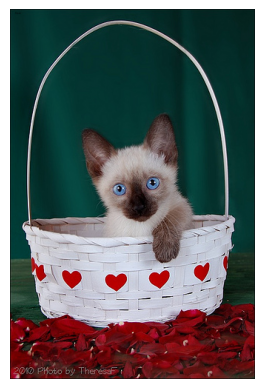

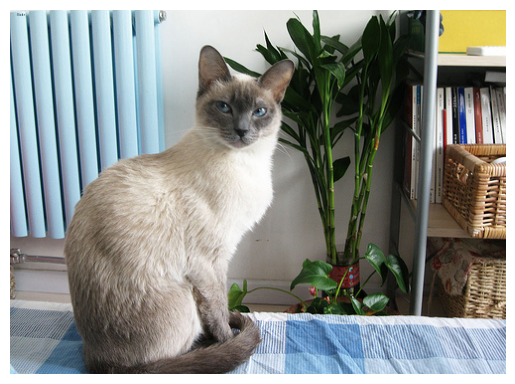

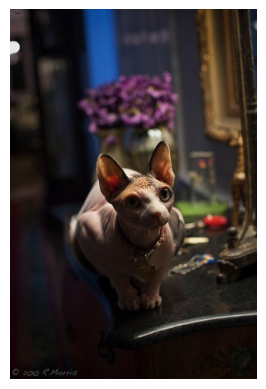

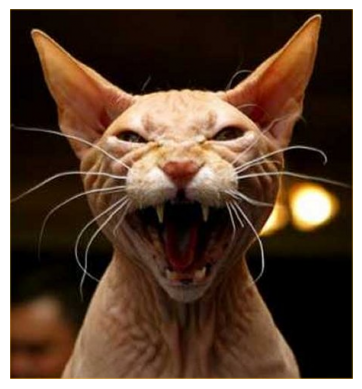

In [13]:
# Función para cargar imágenes de un directorio dado
def load_images_from_directory(directory, num_images=2):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_files = random.sample(image_files, min(len(image_files), num_images))
    images = [mpimg.imread(f) for f in selected_files]
    return images

# Cargar algunas imágenes de los directorios de train y test
train_siamese_images = load_images_from_directory(os.path.join(images_path, "train", "Siamese"))
test_sphynx_images = load_images_from_directory(os.path.join(images_path, "test", "Sphynx"))

# Visualizar las imágenes
def show_images(images):
    for img in images:
        plt.imshow(img / 255.0)
        plt.axis('off')
        plt.show()

# Mostrar algunas imágenes de train y test
show_images(train_siamese_images)
show_images(test_sphynx_images)

# Funciones de preprocesamiento necesarias

In [29]:
# Funciones de preprocesamiento
def apply_fourier_transform(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    magnitude_spectrum = np.uint8(magnitude_spectrum)  # Convertir a uint8
    return cv2.merge([magnitude_spectrum] * 3)  # Convertir a 3 canales para mantener el formato

def apply_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    return masked_img

def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def augment_image(image, img_size):
    """
    Aplica aumentos de datos a la imagen.

    Args:
        image (np.array): Imagen a aumentar.
        img_size (tuple): Tamaño al que se redimensionarán las imágenes.

    Returns:
        list: Lista de imágenes aumentadas.
    """
    augmented_images = []
    angles = [-30, -15, 15, 30]
    translations = [(-10, -10), (-10, 10), (10, -10), (10, 10)]
    scales = [0.8, 1.2]

    for angle in angles:
        aug_img = rotate_image(image, angle)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    for (x, y) in translations:
        aug_img = translate_image(image, x, y)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    for scale in scales:
        aug_img = scale_image(image, scale)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    aug_img = adjust_brightness_contrast(image, alpha=1.5, beta=50)
    aug_img = cv2.resize(aug_img, img_size)
    augmented_images.append(aug_img)

    aug_img = adjust_brightness_contrast(image, alpha=0.5, beta=-50)
    aug_img = cv2.resize(aug_img, img_size)
    augmented_images.append(aug_img)

    return augmented_images

def rotate_image(image, angle):
    """
    Rota la imagen un ángulo especificado.

    Args:
        image (np.array): Imagen a rotar.
        angle (float): Ángulo de rotación en grados.

    Returns:
        np.array: Imagen rotada.
    """
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h))

def translate_image(image, x, y):
    """
    Traduce la imagen en las direcciones x e y especificadas.

    Args:
        image (np.array): Imagen a traducir.
        x (int): Desplazamiento en el eje x.
        y (int): Desplazamiento en el eje y.

    Returns:
        np.array: Imagen traducida.
    """
    M = np.float32([[1, 0, x], [0, 1, y]])
    h, w = image.shape[:2]
    return cv2.warpAffine(image, M, (w, h))

def scale_image(image, scale):
    """
    Escala la imagen por un factor especificado.

    Args:
        image (np.array): Imagen a escalar.
        scale (float): Factor de escala.

    Returns:
        np.array: Imagen escalada.
    """
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w*scale), int(h*scale)))

def extract_sift_features(images):
    """
    Extrae características SIFT de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    sift = cv2.SIFT_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(128))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 128:
            features[i] = np.pad(features[i], (0, max_features * 128 - len(features[i])), mode='constant')

    return np.array(features)

def extract_surf_features(images):
    """
    Extrae características SURF de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    surf = cv2.xfeatures2d.SURF_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = surf.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(64))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 64:
            features[i] = np.pad(features[i], (0, max_features * 64 - len(features[i])), mode='constant')

    return np.array(features)

def extract_orb_features(images):
    """
    Extrae características ORB de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    orb = cv2.ORB_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = orb.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(32))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 32:
            features[i] = np.pad(features[i], (0, max_features * 32 - len(features[i])), mode='constant')

    return np.array(features)


# clase Pipeline de preprocesamiento

In [36]:
class Pipeline:
    def __init__(self, path_siamese, path_sphynx, img_size=(128, 128)):
        self.path_siamese = path_siamese
        self.path_sphynx = path_sphynx
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.preprocess_functions = []

    def add_preprocess_function(self, func):
        self.preprocess_functions.append(func)

    def load_images(self):
        """
        Carga y preprocesa las imágenes de las razas especificadas.

        Returns:
            np.array: Imágenes cargadas y preprocesadas.
            np.array: Etiquetas correspondientes a las imágenes.
        """
        for breed, path in [('Siamese', self.path_siamese), ('Sphynx', self.path_sphynx)]:
            for img_name in os.listdir(path):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(path, img_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, self.img_size)
                        for func in self.preprocess_functions:
                            img = func(img)
                        self.images.append(img)
                        self.labels.append(breed)
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

    def preprocess_image(self, img):
        """
        Aplica las funciones de preprocesamiento a la imagen.

        Args:
            img (np.array): Imagen a preprocesar.

        Returns:
            np.array: Imagen preprocesada.
        """
        for func in self.preprocess_functions:
            img = func(img)
        return img

    def augment_images(self):
        """
        Aplica aumentos de datos a las imágenes cargadas.

        Returns:
            np.array: Imágenes aumentadas.
            np.array: Etiquetas correspondientes a las imágenes aumentadas.
        """
        augmented_images = []
        augmented_labels = []
        for img, label in zip(self.images, self.labels):
            augmented_images.append(img)
            augmented_labels.append(label)
            augmented_set = augment_image(img, self.img_size)
            for aug_img in augmented_set:
                augmented_images.append(aug_img)
                augmented_labels.append(label)
        self.images = np.array(augmented_images)
        self.labels = np.array(augmented_labels)

    def extract_features(self, method='sift'):
        """
        Extrae características de las imágenes usando el método especificado.

        Args:
            method (str): Método de extracción de características ('sift', 'surf', 'orb').

        Returns:
            np.array: Características extraídas.
        """
        if method == 'sift':
            return extract_sift_features(self.images)
        elif method == 'surf':
            return extract_surf_features(self.images)
        elif method == 'orb':
            return extract_orb_features(self.images)
        else:
            raise ValueError("Método de extracción de características no soportado: {}".format(method))

    def apply_tsne(self, features):
        """
        Aplica T-SNE para reducir la dimensionalidad de las características.

        Args:
            features (np.array): Características extraídas.

        Returns:
            np.array: Embedding de T-SNE.
        """
        tsne = TSNE(n_components=2, random_state=42)
        embedding = tsne.fit_transform(features)
        return embedding

    def plot_embedding(self, embedding, title='Embedding of Cat Breeds'):
        """
        Grafica el embedding en 2D con las etiquetas de las imágenes.

        Args:
            embedding (np.array): Embedding de T-SNE o UMAP.
        """
        plt.figure(figsize=(12, 8))
        for i, label in enumerate(np.unique(self.labels)):
            plt.scatter(
                embedding[self.labels == label, 0],
                embedding[self.labels == label, 1],
                label=label
            )
        plt.legend()
        plt.title(title)
        plt.show()

    def train_and_evaluate_model(self, features):
        """
        Entrena y evalúa un modelo de clasificación usando las características extraídas.

        Args:
            features (np.array): Características extraídas.
        """
        X_train, X_test, y_train, y_test = train_test_split(features, self.labels, test_size=0.3, random_state=42)
        model = SVC(kernel='rbf', C=1.0, gamma='scale') 
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        self.model = model  # Guarda el modelo entrenado para predicciones futuras
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(classification_report(y_test, y_pred))


# Preprocesamiento, transformaciones y entrenamiento

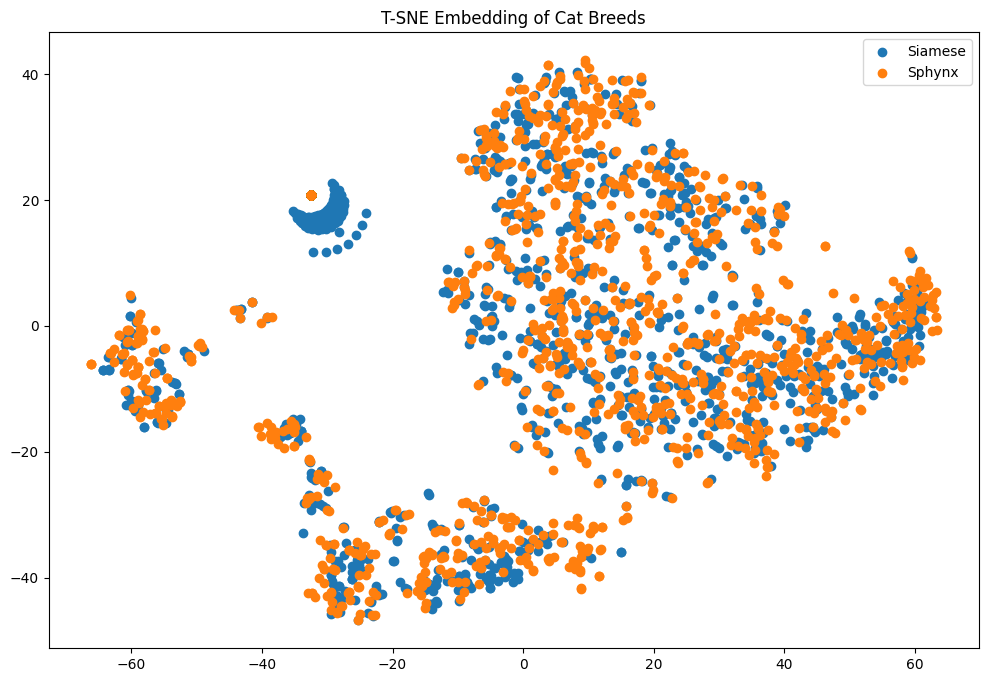

Accuracy: 0.5353925353925354
              precision    recall  f1-score   support

     Siamese       0.52      0.64      0.58       384
      Sphynx       0.55      0.43      0.49       393

    accuracy                           0.54       777
   macro avg       0.54      0.54      0.53       777
weighted avg       0.54      0.54      0.53       777



In [37]:
# Uso de la clase Pipeline
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx)

# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(adjust_brightness_contrast)
pipeline.add_preprocess_function(apply_fourier_transform)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = pipeline.extract_features(method='sift')

# Aplicar T-SNE
embedding_tsne = pipeline.apply_tsne(features)
pipeline.plot_embedding(embedding_tsne, title='T-SNE Embedding of Cat Breeds')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)


In [38]:
def display_predictions(test_images, test_labels, model, preprocess_functions, breeds, img_size=(128, 128), n=10):
    """
    Muestra las predicciones en un conjunto de imágenes.

    Args:
        test_images (list): Lista de rutas de las imágenes de prueba.
        test_labels (list): Lista de etiquetas verdaderas.
        model (object): Modelo entrenado.
        preprocess_functions (list): Lista de funciones de preprocesamiento.
        breeds (list): Lista de razas.
        img_size (tuple): Tamaño al que se redimensionarán las imágenes.
        n (int): Número de imágenes a mostrar.

    Returns:
        None
    """
    images = []
    labels = []
    for img_path, label in zip(test_images, test_labels):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            for func in preprocess_functions:
                img = func(img)
            images.append(img)
            labels.append(breeds.index(label))

    images = np.array(images)
    labels = np.array(labels)

    features = extract_sift_features(images)  # Extraer características
    predictions = model.predict(features)

    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(2, 5, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'True: {breeds[labels[i]]}\nPred: {breeds[predictions[i]]}')
        plt.axis('off')
    plt.show()


In [39]:

test_images = [
    'images/test/Siamese_5.jpg',
    'images/test/Sphynx_2.jpg',
]
test_labels = [
    'Siamese',
    'Sphynx',
]
display_predictions(test_images, test_labels, pipeline.model, pipeline.preprocess_functions, pipeline.breeds)


AttributeError: 'Pipeline' object has no attribute 'breeds'